# Get an abstract description about a country, based on Wikipedia content





## Import libaries and prepare the API credential

In [1]:
import tempfile
import shutil
import os
import subprocess

from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor

with open('openai.credential', 'r') as file:
    key = file.read()
MODEL = 'gpt-4o'

## Create a temporary folder to execute code

In [2]:
temp_dir = tempfile.TemporaryDirectory()
print(temp_dir.name)

subprocess.run(["cp", "population.csv", temp_dir.name+"/"])

os.listdir(temp_dir.name)

/tmp/tmpc8e8t_my


['population.csv']

## Agent 1: code executor, who can run python code locally

In [3]:
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
    is_termination_msg=lambda msg: "terminate" in msg["content"].lower(),
)

## Agent 2: data scientist, who can write python code

In [4]:
data_scientist_system_message = """You are a data scientist, and you can solve problems by writing python code. 
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when the anser is verified.
Some of the tasks are about analyzing a csv file. If you don't know the structure of the csv file, you may provide code to the users to extract the csv structure, and use the feedback from the users to generate the csv analysis code. 
"""

data_scientist = ConversableAgent(
    "data_scientist_agent",
    system_message = data_scientist_system_message,
    llm_config = {"config_list": [{"model": MODEL, "api_key": key}]},
    code_execution_config=False,  # Turn off code execution for this agent.
    is_termination_msg=lambda msg: "terminate" in msg["content"].lower(),
    human_input_mode="NEVER"
)

## Agent 3: data explainer

In [5]:
story_teller = ConversableAgent(
    "story_teller",
    system_message = "Your are a analyzer. If you see a set of data, you try to tell a story about what you understand about the data",
    llm_config = {"config_list": [{"model": MODEL, "api_key": key}]},
    code_execution_config=False
)

## Now we start the sequence: (1) extract the data, (2) draw a bar chat and print the extracted data, (3) explain the data

In [6]:
from tools.tools import second_last_msg

chat_results = code_executor.initiate_chats(
    [
        {
            "recipient": data_scientist,
            "message": "There is a csv file called population.csv, can you find out the number of newborns each year for Norway, and store it in a result.csv file",
            "max_turns": 6,
            "summary_method": "last_msg"
        },
        {
            "recipient": data_scientist,
            "message": "the previous task produced a csv file, could you draw a bar chart for this result, in a result.png file, and print out the content of the csv file in the console",
            "max_turns": 4,
            "summary_method": second_last_msg
        },
        {
            "recipient": story_teller,
            "message": "please write a paragraph to analyze the data from the previous conversations: what does the data tell about? what is the trend?",
            "max_turns": 1,
            "summary_method": "last_msg"
        }
    ]
)

os.listdir(temp_dir.name)


********************************************************************************
Starting a new chat....

********************************************************************************
code_executor_agent (to data_scientist_agent):

There is a csv file called population.csv, can you find out the number of newborns each year for Norway, and store it in a result.csv file

--------------------------------------------------------------------------------
data_scientist_agent (to code_executor_agent):

To achieve this task, we will follow the steps below:
1. Load the CSV file (`population.csv`) and inspect its structure to understand the headers and the type of data it contains.
2. Filter the data for Norway and extract the number of newborns for each year.
3. Store the resulting data in a new CSV file (`result.csv`).

Let's start with the first step:

```python
# Step 1: Load and inspect the CSV file
import pandas as pd

# Load the population.csv file
df = pd.read_csv('population.csv')



/opt/conda/lib/python3.11/site-packages/autogen/agentchat/chat.py:47: UserWarning: Repetitive recipients detected: The chat history will be cleared by default if a recipient appears more than once. To retain the chat history, please set 'clear_history=False' in the configuration of the repeating agent.
  warnings.warn(



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
code_executor_agent (to data_scientist_agent):

exitcode: 0 (execution succeeded)
Code output:   Country name  ...  population__all__95_99__records
0  Afghanistan  ...                                8
1  Afghanistan  ...                                9
2  Afghanistan  ...                               10
3  Afghanistan  ...                               11
4  Afghanistan  ...                               11

[5 rows x 40 columns]


--------------------------------------------------------------------------------
data_scientist_agent (to code_executor_agent):

Given the output and the fact that the dataframe has multiple columns, we need to know which specific column(s) contain the year and the number of newborns. Let's inspect the column names to identify the relevant ones.

```python
# Inspect column names to identify relevant columns
print(df.columns)
```


['result.csv',
 'population.csv',
 'visualize_csv.py',
 'Inspect column names to identify relevant columns',
 'extract_newborns_norway.py',
 'Step 1: Load and inspect the CSV file',
 'inspect_columns.py',
 'result.png']

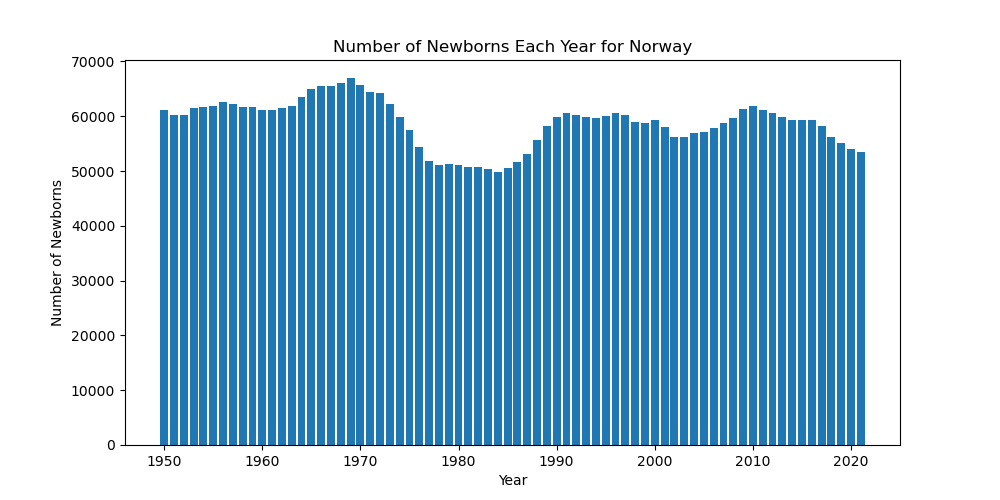

In [7]:
chart = "result.png"
from PIL import Image
from IPython.display import display
img = Image.open(temp_dir.name + "/" + chart)
display(img)

## Exercise
To understand context: we describe the requirement for a funciton (e.g., for an even number n, return two prime numbers whose sum is n), and execute 4 tasks in a sequence:
 1. generate the test case
 1. generate the function code
 1. test the function
 1. write a document to explain the function and evaluate the test case

Question: how to postpone the execution of output from 1.1?

